# Read the data 

For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. During some of the other lessons, we combined the following datasets into a single, clean pandas dataframe:

1.SAT scores by school - SAT scores for each high school in New York City<br>

2.School attendance - Attendance information for each school in New York City<br>

3.Class size - Information on class size for each school<br>

4.AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)<br>

5.Graduation outcomes - The percentage of students who graduated and other outcome information<br>

6.Demographics - Demographic information for each school<br>

7.School survey - Surveys of parents, teachers, and students at each school<br>

In [2]:
import matplotlib as plt

In [5]:
import pandas as pd
import numpy as np
import re
data_files = [
       "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d= pd.read_csv("schools/{0}".format(f))
    data[f.replace('.csv','')] = d



# Read in the surveys

In [7]:
all_survey = pd.read_csv("schools/survey_all.txt",delimiter="\t",encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt",delimiter="\t",encoding='windows-1252')
survey = pd.concat([all_survey,d75_survey],axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns 
##  hs_directory.csv- 高中目录

In [11]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_scd(num):
  return str(num).zfill(2)
data["class_size"]['padded_csd'] = data["class_size"]['CSD'].apply(pad_scd)
data["class_size"]['DBN'] = data["class_size"]['padded_csd']+data["class_size"]['SCHOOL CODE']

# Convert columns to numeric

In [13]:
col = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in col:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c],errors="coerce")
data["sat_results"]["sat_score"] = data['sat_results'][col[0]]+data['sat_results'][col[1]]+data['sat_results'][col[2]]


In [15]:
import re
def find_lat(loc):
    coords = re.findall("\(.+\)",loc)
    lat = coords[0].split(',')[0].replace("(","")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+\)",loc)
    lon = coords[0].split(',')[1].replace(")","")
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)


data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"] ,errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"] ,errors="coerce")



# Condense datasets

In [16]:
import numpy as np
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "]=="09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] =class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"]== 20112012]

data['graduation'] = data['graduation'][(data["graduation"]["Cohort"] == "2006")&(data["graduation"]["Demographic"] == "Total Cohort")]

# Convert AP scores to numeric

In [18]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col],errors="coerce")
    

# Combine the datasets

In [19]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"],on='DBN',how='left')
combined = combined.merge(data["graduation"],on='DBN',how='left')

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined =combined.merge(data[m],on="DBN",how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [20]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [21]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [28]:
correlations.head()

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
Name: sat_score, dtype: float64

# plotting survey correlations

In [24]:
survey_fields.remove("DBN")

In [43]:
import matplotlib as plt
%matplotlib inline
plt.figure(figsize=(6,8))

TypeError: 'module' object is not callable

<AxesSubplot:>

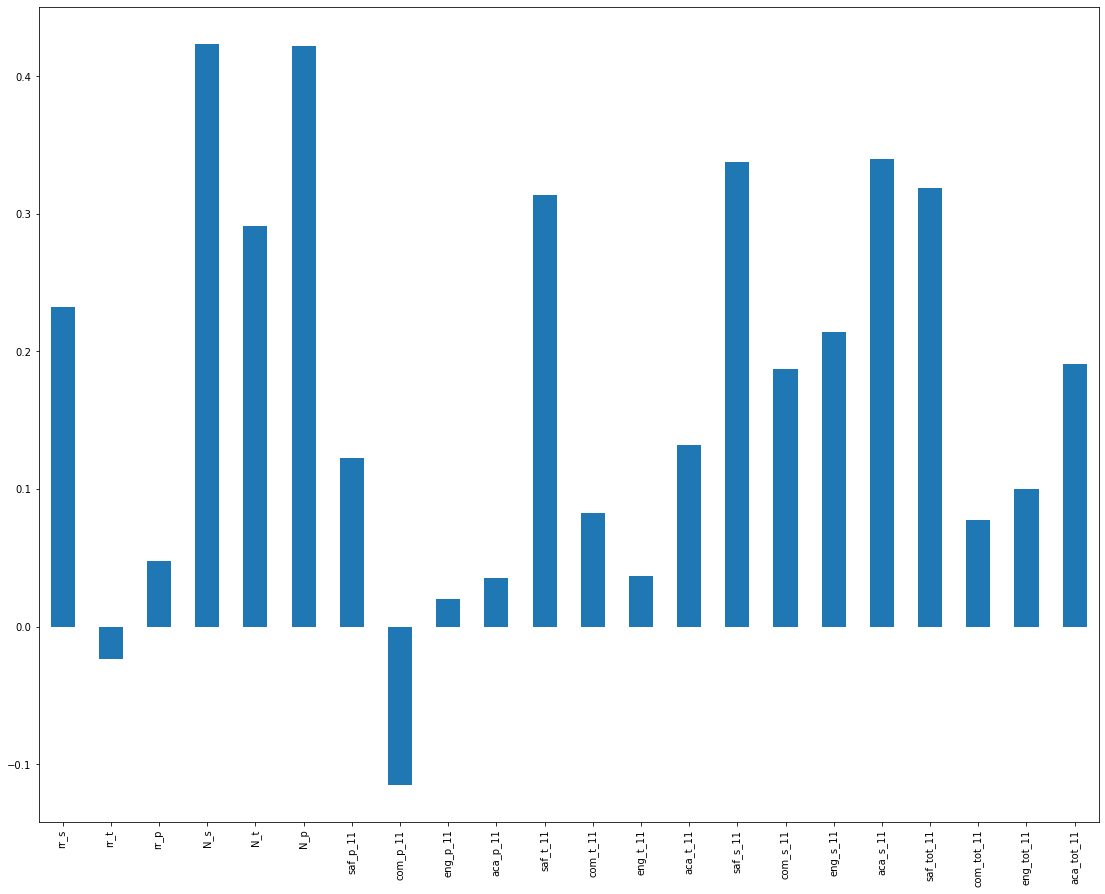

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(19, 15))
correlations[survey_fields].plot.bar()


There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Explore safety 

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

<Figure size 720x360 with 0 Axes>

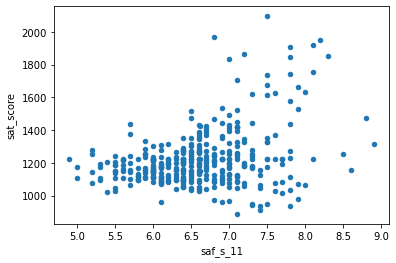

In [52]:

plt.figure(figsize=(10, 5))
combined.plot.scatter(x='saf_s_11',y='sat_score')

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.



# borough safety

In [55]:
boros = combined.groupby("boro").agg(np.mean)['saf_s_11']
boros

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.



# Racial different in SAT scores

<AxesSubplot:>

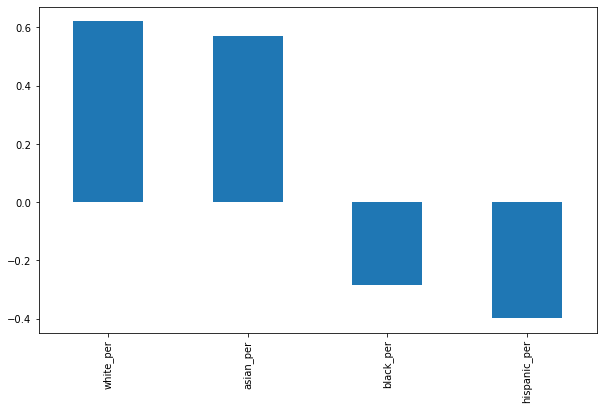

In [60]:
racial_filed = ['white_per','asian_per','black_per','hispanic_per']

plt.figure(figsize=(10,6))
correlations[racial_filed].plot.bar()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

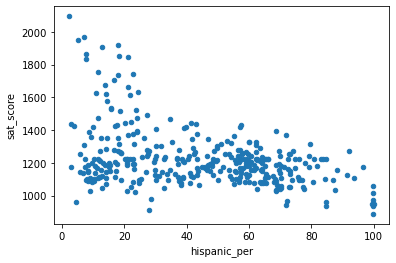

In [61]:
combined.plot.scatter(x='hispanic_per',y='sat_score')

In [68]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.



In [69]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gende different in sat scores

<AxesSubplot:>

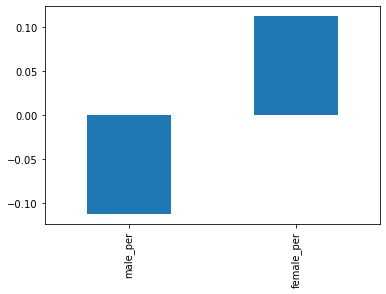

In [71]:
gender_fileds= ['male_per','female_per']
correlations[gender_fileds].plot.bar()

## Investigate schools with high SAT scores and a high female_per

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

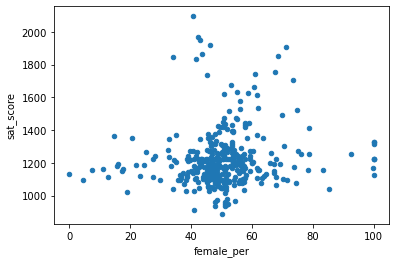

In [72]:
combined.plot.scatter(x = 'female_per',y="sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [73]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.



In [75]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

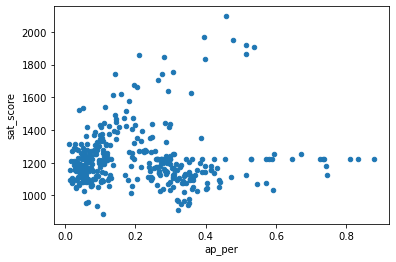

In [76]:
combined.plot.scatter(x='ap_per',y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.